<a href="https://colab.research.google.com/github/tomiambro/covid_transfer_learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install --upgrade git+https://github.com/fastai/fastai.git &> 2
!pip install pip install nbdev &> 2

# Covid detection using CT Scans

In [ ]:
from fastai.vision.all import *
from torchvision import transforms as T

import gc

In [ ]:
dataset_path = 'gdrive/MyDrive/machine_learning/datasets/covid_dataset'  #change dir to your project folder
folder_path = 'gdrive/MyDrive/machine_learning/covid/'

res = pd.DataFrame({'model':[], 'f1_score':[] , 'recall_score': []})

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


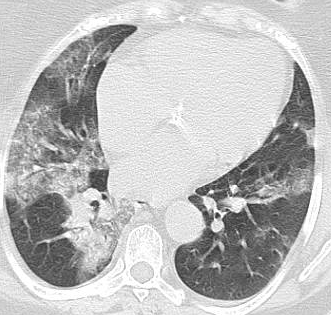

In [ ]:
im = Image.open(f"{dataset_path}/COVID/Covid (1000).png")
im.to_thumb(350,350)

Create array with Path objects to imgs

In [ ]:
path = Path(f"{dataset_path}")

In [ ]:
imgs = get_image_files(f"{dataset_path}")
imgs[:5]

(#5) [Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1227).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1229).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1226).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1209).png'),Path('gdrive/MyDrive/machine_learning/datasets/covid_dataset/COVID/Covid (1238).png')]

In [ ]:
covid = DataBlock(
    blocks=(ImageBlock, CategoryBlock(['non-COVID', 'COVID'], sort=False)), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(350,350))

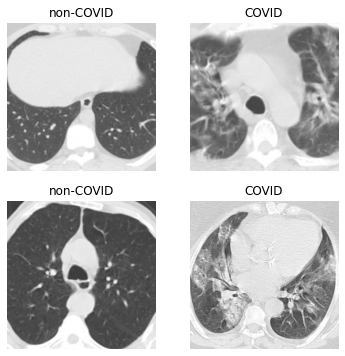

In [ ]:
dls = covid.dataloaders(path)
dls.valid.show_batch(max_n=4)

In [ ]:
res34 = vision_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
lr = 1e-3
res34.fine_tune(4, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.932290,0.499353,0.813492,0.843621,00:32
1,0.668796,0.348814,0.870056,0.950617,00:25


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.300832,0.188470,0.928571,0.909465,00:27
1,0.198672,0.165978,0.947368,0.925926,00:29
2,0.126549,0.117140,0.958506,0.950617,00:28
3,0.079532,0.110010,0.965092,0.967078,00:28


In [ ]:
df_rec34 = pd.DataFrame(res34.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [ ]:
df_rec34

,train_loss,valid_loss,f1_score,recall_score
0,0.300832,0.188470,0.928571,0.909465
1,0.198672,0.165978,0.947368,0.925926
2,0.126549,0.117140,0.958506,0.950617
3,0.079532,0.110010,0.965092,0.967078


In [ ]:
res = res.append({'model':'res34', 'f1_score': df_rec34['f1_score'].iloc[-1], 'recall_score':df_rec34['recall_score'].iloc[-1]}, ignore_index=True)
res

,model,f1_score,recall_score
0,res34,0.965092,0.967078


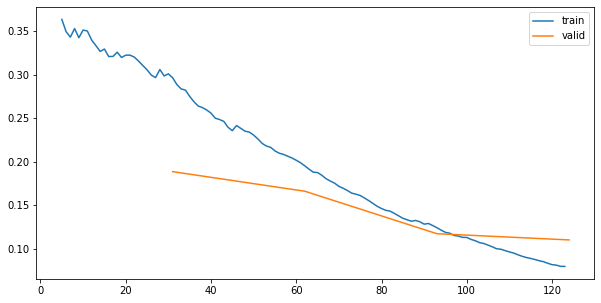

In [ ]:
plt.figure(figsize=(10,5))
res34.recorder.plot_loss()

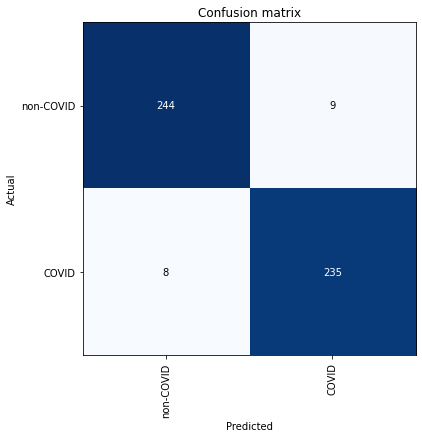

In [ ]:
interp = ClassificationInterpretation.from_learner(res34)
interp.plot_confusion_matrix(figsize=(6,6))

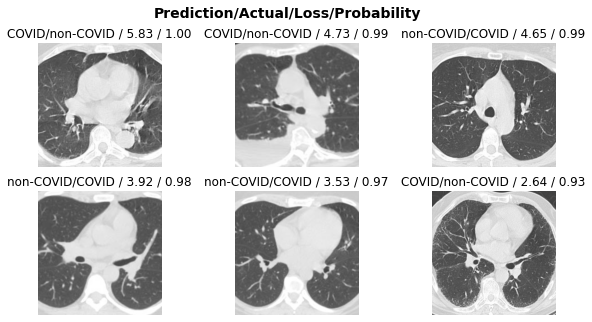

In [ ]:
interp.plot_top_losses(6, figsize=(10,5))

In [ ]:
res34.predict(f"{dataset_path}/COVID/Covid (1000).png")

('COVID', TensorBase(1), TensorBase([2.0324e-06, 1.0000e+00]))

In [ ]:
res34.export('res34.pkl')

In [ ]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, Contrast(p=1, draw=1.50)])

dls = covid.dataloaders(path)

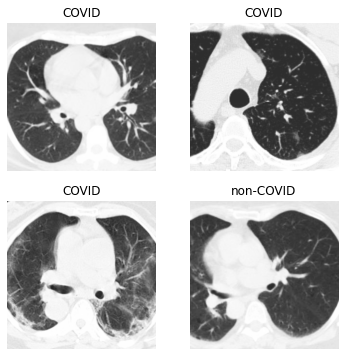

In [ ]:
dls.train.show_batch(max_n=4)

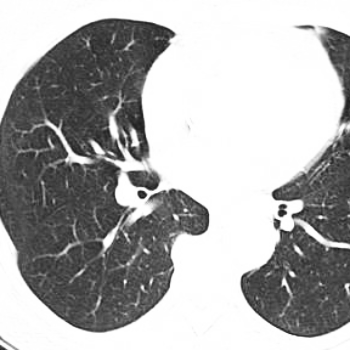

In [ ]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [ ]:
res34_con = vision_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
lr = 1e-3
res34_con.fine_tune(5, lr, freeze_epochs=1)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.808099,0.650402,0.751678,0.921811,00:25


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.416204,0.508827,0.830716,0.979424,00:29
1,0.286704,0.212344,0.921811,0.921811,00:29
2,0.201143,0.166797,0.947368,0.962963,00:29
3,0.132617,0.180401,0.932271,0.962963,00:29
4,0.091485,0.167086,0.939516,0.958848,00:28


In [ ]:
df_rec34_con = pd.DataFrame(res34_con.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [ ]:
df_rec34_con

,train_loss,valid_loss,f1_score,recall_score
0,0.416204,0.508827,0.830716,0.979424
1,0.286704,0.212344,0.921811,0.921811
2,0.201143,0.166797,0.947368,0.962963
3,0.132617,0.180401,0.932271,0.962963
4,0.091485,0.167086,0.939516,0.958848


In [ ]:
res = res.append({'model':'res34_con', 'f1_score': df_rec34_con['f1_score'].iloc[-1], 'recall_score':df_rec34_con['recall_score'].iloc[-1]}, ignore_index=True)
res.sort_values('f1_score', ascending=False)

,model,f1_score,recall_score
0,res34,0.965092,0.967078
1,res34_con,0.939516,0.958848


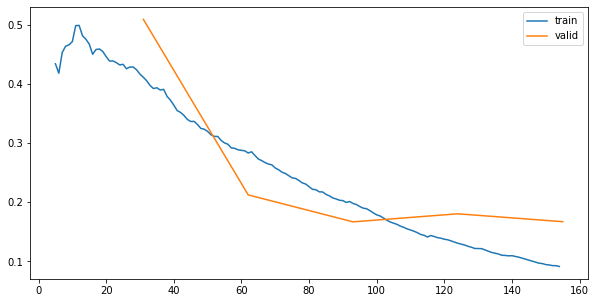

In [ ]:
plt.figure(figsize=(10,5))
res34_con.recorder.plot_loss()

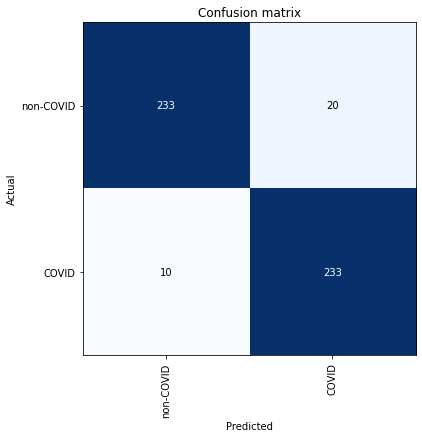

In [ ]:
interp = ClassificationInterpretation.from_learner(res34_con)
interp.plot_confusion_matrix(figsize=(6,6))

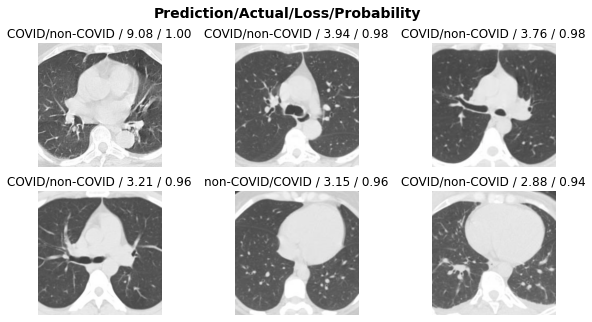

In [ ]:
interp.plot_top_losses(6, figsize=(10,5))

In [ ]:
res34_con.export('res34_con.pkl')

In [ ]:
covid = covid.new(
    item_tfms=Resize(350,350),
    batch_tfms=[DeterministicFlip, RandomErasing(1, min_aspect=0.3, sh=0.1)])

dls = covid.dataloaders(path)

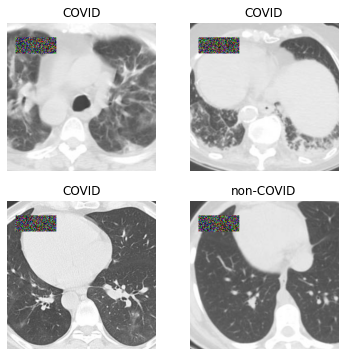

In [ ]:
dls.train.show_batch(max_n=4)

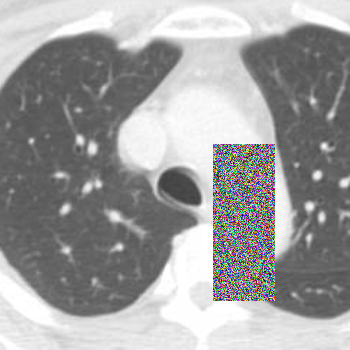

In [ ]:
train_features, train_labels = next(iter(dls.train))
trans = T.ToPILImage()
trans(train_features[0])

In [ ]:
res34_noise = vision_learner(dls, resnet34, metrics=[F1Score(), Recall()], path=folder_path)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
lr = 1e-3
res34_noise.fine_tune(5, lr, freeze_epochs=2)

epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.909470,0.484087,0.791011,0.724280,00:26
1,0.691455,0.318237,0.862745,0.814815,00:26


epoch,train_loss,valid_loss,f1_score,recall_score,time
0,0.452397,0.267486,0.904762,0.860082,00:28
1,0.337937,0.175878,0.924335,0.930041,00:28
2,0.264211,0.128840,0.956522,0.950617,00:28
3,0.198300,0.113766,0.966942,0.962963,00:28
4,0.165249,0.110548,0.964948,0.962963,00:29


In [ ]:
df_rec34_noise = pd.DataFrame(res34_noise.recorder.values, columns=['train_loss', 'valid_loss', 'f1_score', 'recall_score'])

In [ ]:
df_rec34_noise

,train_loss,valid_loss,f1_score,recall_score
0,0.452397,0.267486,0.904762,0.860082
1,0.337937,0.175878,0.924335,0.930041
2,0.264211,0.128840,0.956522,0.950617
3,0.198300,0.113766,0.966942,0.962963
4,0.165249,0.110548,0.964948,0.962963


In [ ]:
res = res.append({'model':'res34_noise', 'f1_score': df_rec34_noise['f1_score'].iloc[-1], 'recall_score':df_rec34_noise['recall_score'].iloc[-1]}, ignore_index=True)
res.sort_values('f1_score', ascending=False)

,model,f1_score,recall_score
0,res34,0.965092,0.967078
2,res34_noise,0.964948,0.962963
1,res34_con,0.939516,0.958848


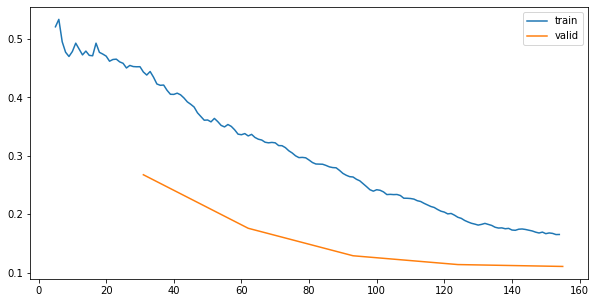

In [ ]:
plt.figure(figsize=(10,5))
res34_noise.recorder.plot_loss()

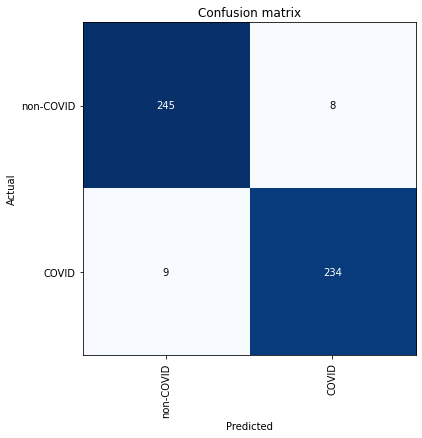

In [ ]:
interp = ClassificationInterpretation.from_learner(res34_noise)
interp.plot_confusion_matrix(figsize=(6,6))

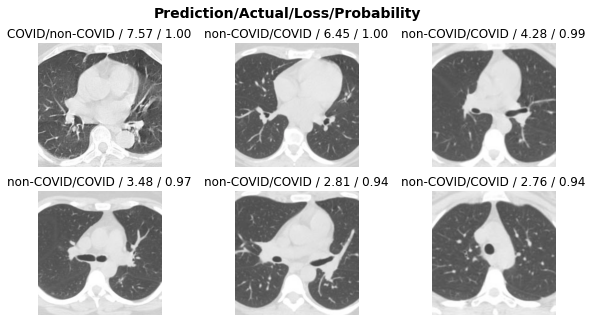

In [ ]:
interp.plot_top_losses(6, figsize=(10,5))

In [ ]:
res34_noise.export('res34_noise.pkl')

## Inference and Ensembling

In [ ]:
class Ensemble:
  def __init__(self, dls, models : dict, vocab : list=[0, 1]):
    self.models = models
    self.vocab = vocab
    self.dls = dls
    self.model_list = models.values()
    print(f'vocab: {self.vocab}')
    for name, model in models.items():
      print(f'loaded: {name}')


  def calc_probas(self, item):
    probas = []
    for _, model in self.models.items():
      _, _, p = model.predict(item)
      probas.append(p)
    
    probas = torch.stack(probas, dim=0)
    return probas

  def predict(self, item):
    probas = self.calc_probas(item)
    mean, std = probas.mean(axis=0), probas.std(axis=0)

    return self.vocab[mean.argmax()], mean.argmax(), std
  
  def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None, inner=False, reorder=True, cbs=None, **kwargs):
    
    if dl is None: dl = self.dls[1]

    predictions = []
    losses = []
    res = []

    for name, model in self.models.items():
      print(f'Getting predictions from {name} \n')
      inputs, preds, targs, decoded, loss = model.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True)
      predictions.append(preds)
      losses.append(loss)
    
    preds = torch.stack(predictions).mean(0)
    decoded = preds.argmax(1)
    
    if with_input:
      res.append(inputs)
    
    res.append(preds)
    res.append(targs)

    if with_decoded:
      res.append(decoded)
    
    if with_loss:
      res.append(torch.stack(losses, dim=1).mean(1))
    
    return tuple(res)

  def calc_metrics(self, metrics : dict):
    res = {}
    predictions, targs, decoded, losses = self.get_preds(dl=self.dls.valid, with_input=False, with_loss=True, with_decoded=True)
    for name, metric in metrics.items():
      res[name] = metric(decoded, targs)
    return res

In [ ]:
en = Ensemble(dls, {'res34': res34, 'res34_con': res34_con, 'res34_noise': res34_noise}, vocab=dls.valid.vocab)
pred, mean, std = en.predict(f"{dataset_path}/COVID/Covid (1000).png")

vocab: ['non-COVID', 'COVID']
loaded: res34
loaded: res34_con
loaded: res34_noise


Prediction, probabilities and standard deviation for *item*.

In [ ]:
en.predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('non-COVID', TensorBase(0), TensorBase([0.4803, 0.4803]))

Accessing a single model from within the Ensemble

In [ ]:
en.models['res34_noise'].predict(f"{dataset_path}/non-COVID/Non-Covid (200).png")

('non-COVID', TensorBase(0), TensorBase([0.9682, 0.0318]))

In [ ]:
inputs_o, predictions_o, targs_o, decoded_o, losses_o = en.models['res34_noise'].get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True)

Calculate predictions for a whole dl

In [ ]:
inputs, predictions, targs, decoded, losses = en.get_preds(dl=dls.valid, with_input=True, with_loss=True, with_decoded=True)

Getting predictions from res34 



Getting predictions from res34_con 



Getting predictions from res34_noise 



Checks to verify shape and type match those of fast.ai

In [ ]:
assert losses_o.shape == losses.shape
assert targs_o.shape == targs.shape
assert decoded_o.shape == decoded.shape
assert predictions_o.shape == predictions.shape
assert inputs_o.shape == inputs.shape

In [ ]:
assert type(losses_o) == type(losses)
assert type(targs_o) == type(targs)
assert type(decoded_o) == type(decoded)
assert type(predictions_o) == type(predictions)

Calculate metrics.

In [ ]:
results = en.calc_metrics({'F1Score': F1Score(), 'Recall': Recall()})

Getting predictions from res34 



Getting predictions from res34_con 



Getting predictions from res34_noise 



In [ ]:
res = res.append({'model':'ensemble', 'f1_score': results['F1Score'], 'recall_score':results['Recall']}, ignore_index=True)
res.sort_values('f1_score', ascending=False)

,model,f1_score,recall_score
3,ensemble,0.975207,0.971193
0,res34,0.965092,0.967078
2,res34_noise,0.964948,0.962963
1,res34_con,0.939516,0.958848


Getting predictions from res34 



Getting predictions from res34_con 



Getting predictions from res34_noise 



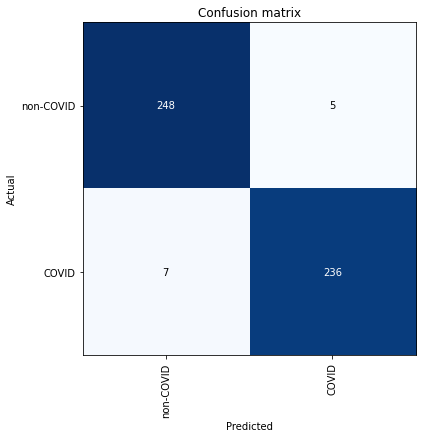

In [ ]:
interp = ClassificationInterpretation(en, dls.valid, losses)
interp.plot_confusion_matrix(figsize=(6,6))

Getting predictions from res34 



Getting predictions from res34_con 



Getting predictions from res34_noise 



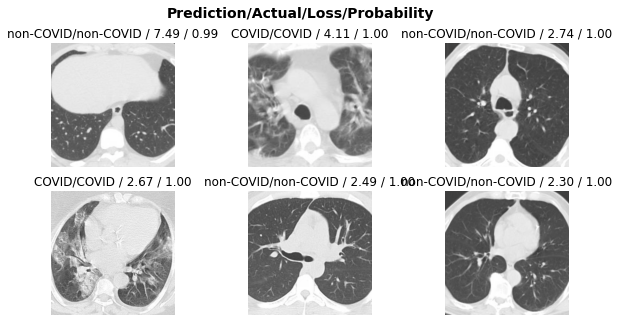

In [ ]:
interp.plot_top_losses(6, figsize=(10,5))